# Лабораторная 5

Датасет: Информация об онлайн обучении учеников

## Бизнес-цель
Улучшение доступа к онлайн-образованию для учеников с низким уровнем финансового обеспечения.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("..\\static\\csv\\students_adaptability_level_online_education.csv")
print(df.columns)

map_flexibility_to_int = {'Low': 0, 'Moderate': 1, 'High': 2}

df['Flexibility Level'] = df['Flexibility Level'].map(map_flexibility_to_int).astype('int32')

Index(['Education Level', 'Institution Type', 'Gender', 'Age', 'Device',
       'IT Student', 'Location', 'Financial Condition', 'Internet Type',
       'Network Type', 'Flexibility Level'],
      dtype='object')


Конвеер из 4 лабораторной

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# columns_to_drop = ['Age', 'Education Level', 'Gender', 'IT Student', 'Flexibility Level']
num_columns = [
    column
    for column in df.columns
    if df[column].dtype != "object"
]
cat_columns = [
    column
    for column in df.columns
    if df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

preprocessing_result = pipeline_end.fit_transform(df)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

Age  Flexibility Level  Education Level_School  \
0     1.018272           0.510309                     0.0   
1     1.018272           0.510309                     0.0   
2     0.160338           0.510309                     0.0   
3    -1.040771           0.510309                     1.0   
4     0.160338          -1.107907                     1.0   
...        ...                ...                     ...   
1200  0.160338          -1.107907                     0.0   
1201  0.160338           0.510309                     0.0   
1202 -1.040771           0.510309                     1.0   
1203  0.160338          -1.107907                     0.0   
1204 -1.040771           0.510309                     1.0   

      Education Level_University  Institution Type_Public  Gender_Male  \
0                            1.0                      0.0          1.0   
1                            1.0                      0.0          0.0   
2                            0.0                      1.0          0.0   
3                            0.0                      0.0          0.0   
4                            0.0                      0.0          0.0   
...                          ...                      ...          ...   
1200                         0.0                      0.0          0.0   
1201                         0.0                      0.0          0.0   
1202                         0.0                      0.0          1.0   
1203                         0.0                      0.0          0.0   
1204                         0.0                      0.0          0.0   

      Device_Mobile  Device_Tab  IT Student_Yes  Location_Town  \
0               0.0         1.0             0.0            1.0   
1               1.0         0.0             0.0            1.0   
2               1.0         0.0             0.0            1.0   
3               1.0         0.0             0.0            1.0   
4               1.0         0.0             0.0            1.0   
...             ...         ...             ...            ...   
1200            1.0         0.0             0.0            1.0   
1201            1.0         0.0             0.0            0.0   
1202            1.0         0.0             0.0            1.0   
1203            1.0         0.0             0.0            0.0   
1204            1.0         0.0             0.0            1.0   

      Financial Condition_Poor  Financial Condition_Rich  Internet Type_Wifi  \
0                          0.0                       0.0                 1.0   
1                          0.0                       0.0                 0.0   
2                          0.0                       0.0                 1.0   
3                          0.0                       0.0                 0.0   
4                          1.0                       0.0                 0.0   
...                        ...                       ...                 ...   
1200                       0.0                       0.0                 1.0   
1201                       0.0                       0.0                 1.0   
1202                       0.0                       0.0                 0.0   
1203                       0.0                       0.0                 1.0   
1204                       1.0                       0.0                 0.0   

      Network Type_3G  Network Type_4G  
0                 0.0              1.0  
1                 0.0              1.0  
2                 0.0              1.0  
3                 0.0              1.0  
4                 1.0              0.0  
...               ...              ...  
1200              0.0              1.0  
1201              0.0              1.0  
1202              1.0              0.0  
1203              0.0              1.0  
1204              1.0              0.0  

[1205 rows x 15 columns]

Понижение размерности (PCA) и визуализация данных.

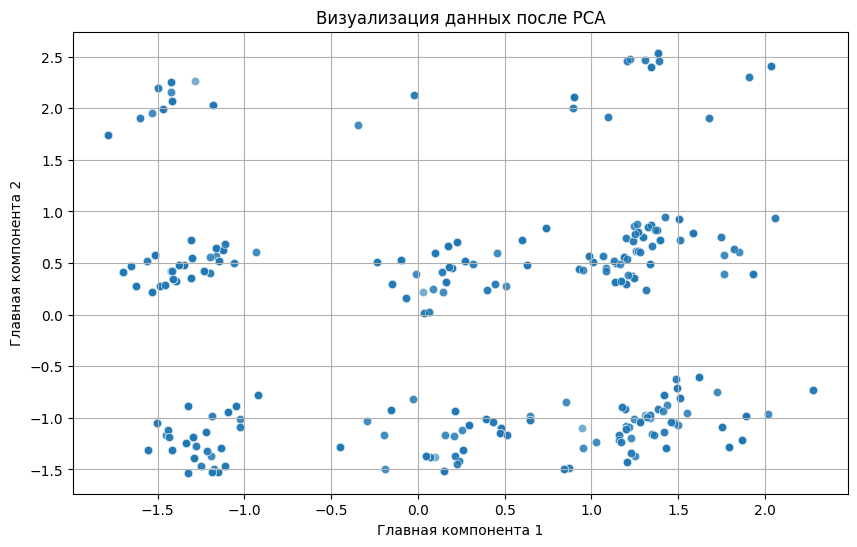

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

rnd_state=9

pca = PCA(n_components=2, random_state=rnd_state)
data_pca = pca.fit_transform(preprocessed_df)

df_pca = pd.DataFrame(data_pca, columns=['Principal Component 1', 'Principal Component 2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    data=df_pca,
    alpha=0.6
)
plt.title('Визуализация данных после PCA')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

Выбор количества кластеров с помощью двух методов: инерция и коэффициент силуэта.

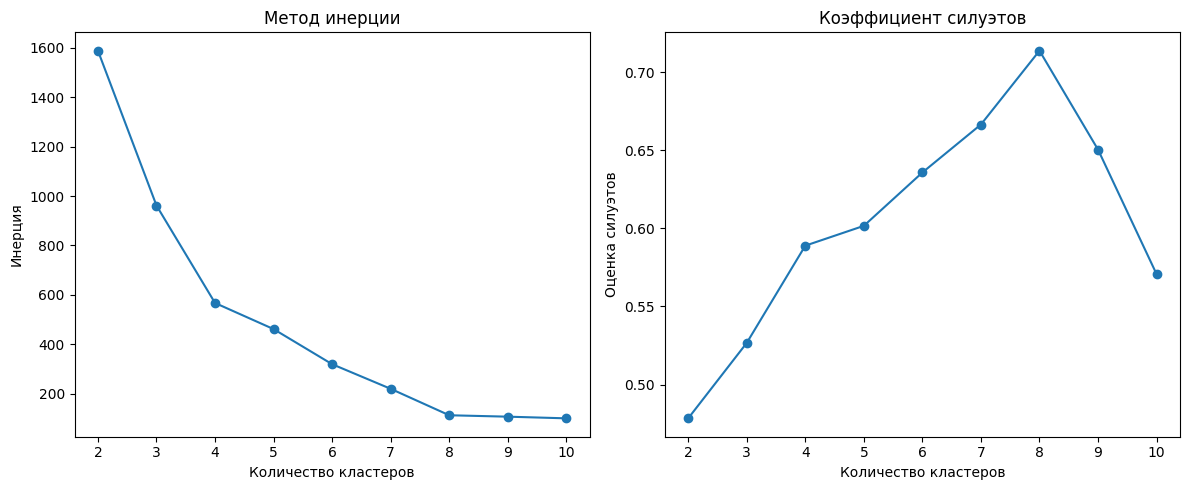

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
os.environ['OMP_NUM_THREADS'] = '12'

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=rnd_state)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_pca, kmeans.labels_, random_state=rnd_state))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Метод инерции')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэтов')
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка силуэтов')

plt.tight_layout()
plt.show()

Судя по графикам видно, что при n=8 коэффициент силуэтов максимален, а уменьшение инерции минимально. Выбираем n=8.

In [11]:
clusters_count = 8

Кластерный анализ. Иерархическая и неиерархическая кластеризация.

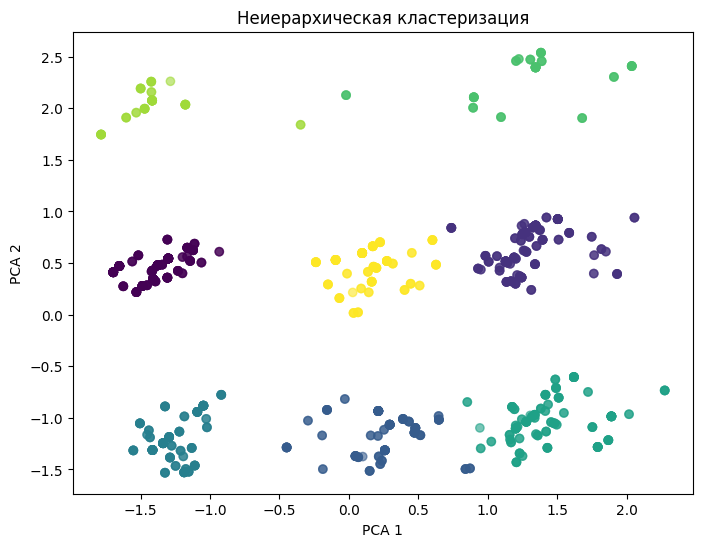

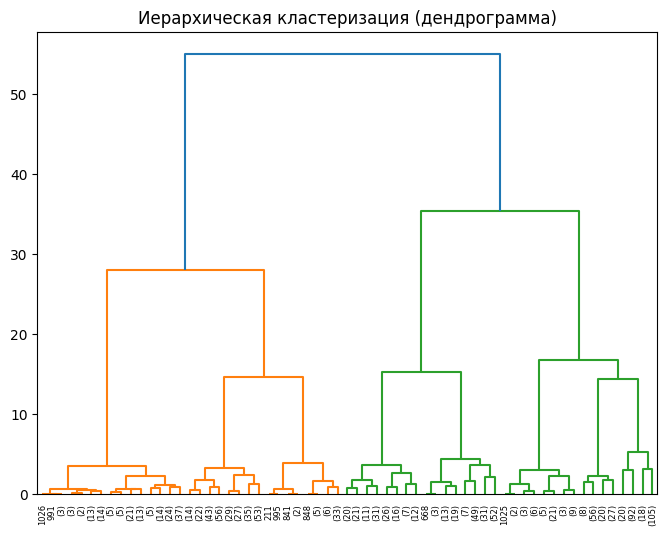

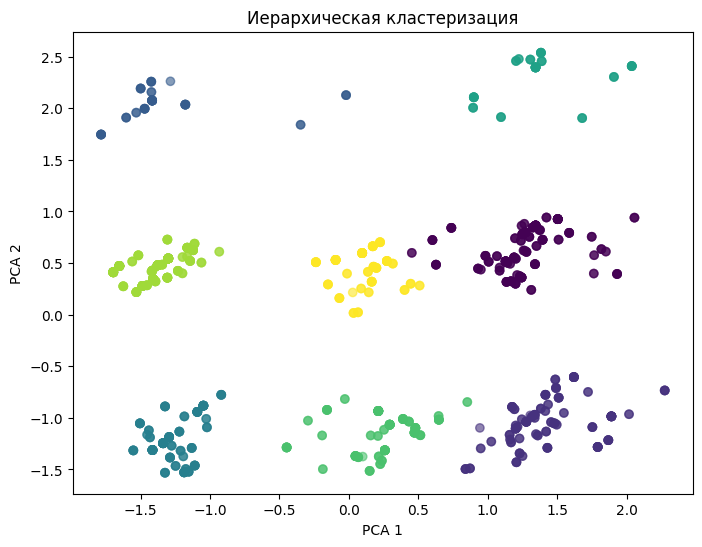

In [25]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

kmeans = KMeans(n_clusters=clusters_count, random_state=rnd_state)
kmeans_labels = kmeans.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('Неиерархическая кластеризация')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=clusters_count)
hierarchical_labels = hierarchical.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
linkage_matrix = linkage(data_pca, method='ward')
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.6)
plt.title('Иерархическая кластеризация')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Оценка качества кластеризации коэффициентом силуэта

In [26]:
silhouette_kmeans = silhouette_score(data_pca, kmeans_labels, random_state=rnd_state)
silhouette_hierarchical = silhouette_score(data_pca, hierarchical_labels, random_state=rnd_state)

print(f'Silhouette Score for KMeans: {silhouette_kmeans:.4f}')
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical:.4f}')

Silhouette Score for KMeans: 0.7138
Silhouette Score for Hierarchical Clustering: 0.7077


С небольшим отрывом побеждает неиерархическая кластеризация (KMeans)